<a href="https://colab.research.google.com/github/gemme/resnet18/blob/resnet50/Resnet50__neumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf
import tensorflow.nn as nn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Flatten,Conv2D,MaxPooling2D,Add, AveragePooling2D
from google.colab import drive
print(nn)
drive.flush_and_unmount()
drive.mount('/content/drive')
#_URL='https://data.mendeley.com/datasets/rscbjbr9sj/2/files/f12eaf6d-6023-432f-acc9-80c9d7393433/ChestXRay2017.zip'
_URL='file:///content/drive/MyDrive/pneumonia2.zip'
zip_dir = tf.keras.utils.get_file('pneumonia2.zip', origin=_URL, extract=True,cache_dir='/content',archive_format='auto')
print(zip_dir)


<module 'tensorflow.nn' from '/usr/local/lib/python3.8/dist-packages/tensorflow/_api/v2/nn/__init__.py'>
Drive not mounted, so nothing to flush and unmount.


In [ ]:
import numpy as np 
import random
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import cv2
import tensorflow
import keras
from keras.metrics import Recall
from keras import Model, callbacks
from keras.layers import Input, Dense, add, Conv2D, MaxPool2D ,GlobalAveragePooling2D, Dropout, BatchNormalization, ZeroPadding2D, ReLU, GlobalAvgPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras import activations
from tensorflow.keras.regularizers import l2
import warnings
import os
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'


In [ ]:
train_path = '/content/datasets/chest_xray/train'
valid_path = '/content/datasets/chest_xray/val'
test_path = '/content/datasets/chest_xray/test'

In [ ]:
BATCH_SIZE = 64
EPOCHS = 20
IMAGE_SIZE = (200, 200)
class_types=['NORMAL', 'PNEUMONIA']
train_dataset = image_dataset_from_directory(train_path,
                                             seed=42,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMAGE_SIZE)

valid_dataset = image_dataset_from_directory(valid_path,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMAGE_SIZE)

test_dataset = image_dataset_from_directory(test_path,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMAGE_SIZE)


rescale = Rescaling(scale=1.0 / 255)
train_dataset = train_dataset.map(lambda image, label: (rescale(image), label))
valid_dataset  = valid_dataset.map(lambda image, label: (rescale(image), label))
test_dataset  = test_dataset.map(lambda image, label: (rescale(image), label))

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [ ]:
cnt_imgs = 16  # we take 8 images for each class
norm_path = train_path + '/NORMAL'
pneumonia_path = train_path + '/PNEUMONIA'
norm_imgs = os.listdir(norm_path)[:cnt_imgs]
pneumonia_imgs = os.listdir(pneumonia_path)[:cnt_imgs]

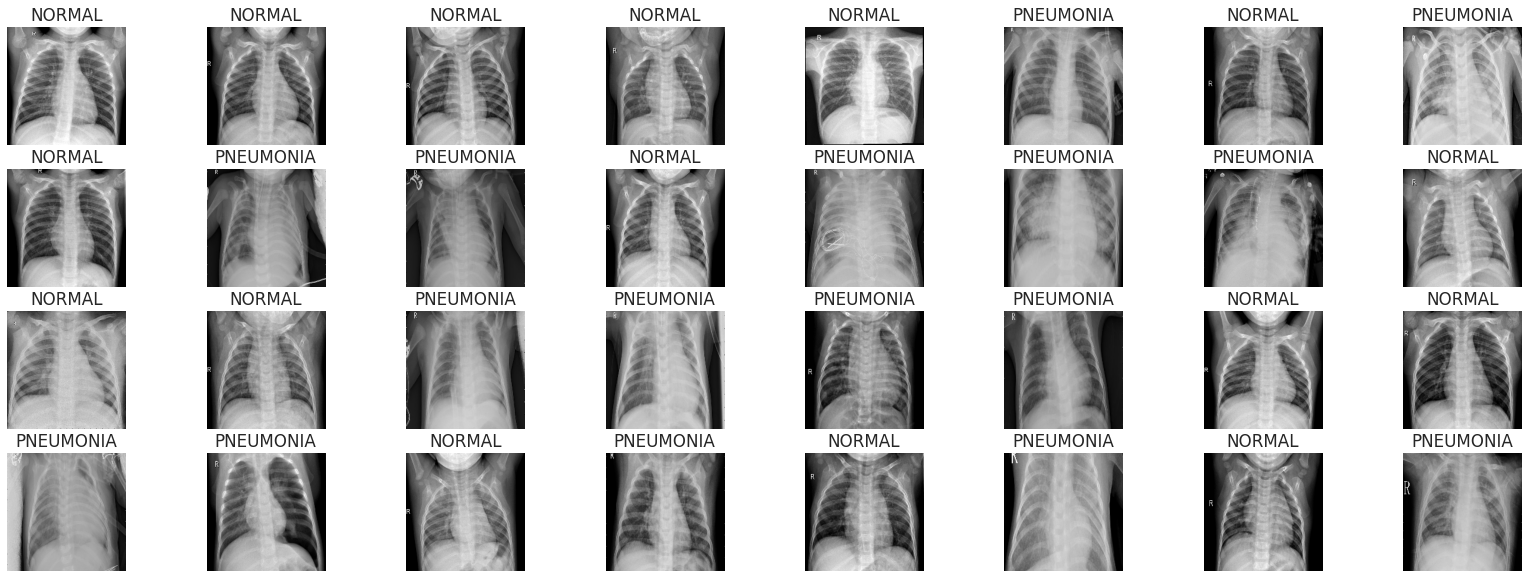

In [ ]:
counter = 0
norm_imgs_path = [norm_path + '/' + i for i in norm_imgs]
pneumonia_imgs_path = [pneumonia_path + '/' + j for j in pneumonia_imgs]
all_imgs = norm_imgs_path + pneumonia_imgs_path
random.shuffle(all_imgs)

plt.figure(figsize=(28, 10))
for img_path in all_imgs:
    plt.subplot(4, 8, counter + 1)
    img = cv2.imread(img_path)
    img = cv2.resize(img, IMAGE_SIZE)
    label = img_path[len(train_path) + 1: img_path.rfind('/')]
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
    counter += 1

In [ ]:
def check_cnt_label(label: str) -> int:
    """A function that should determine the number of objects of this
    class in the specified directories"""
    cnt_object = 0
    paths = [train_path, valid_path, test_path]
    for path in paths:
        path += '/' + label
        cnt_object += len(os.listdir(path))
    return cnt_object

CNT_NORMAL = check_cnt_label('NORMAL')
CNT_PNEUMONIA = check_cnt_label('PNEUMONIA')

In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['NORMAL', 'PNEUMONIA'],
    y=[CNT_NORMAL, CNT_PNEUMONIA],
    name='Primary Product',
    marker_color='indianred',
    width=[0.4, 0.4]))

fig.update_layout(title='Classes and their number in the dataset', title_x=0.5)

In [ ]:
def conv_batchnorm_relu(x, filters, kernel_size, strides=1):
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

In [ ]:
def identity_block(tensor, filters):
    x = conv_batchnorm_relu(tensor, filters=filters, kernel_size=1, strides=1)
    x = conv_batchnorm_relu(x, filters=filters, kernel_size=3, strides=1)
    x = Conv2D(filters=4*filters, kernel_size=1, strides=1)(x)
    x = BatchNormalization()(x)
    x = Add()([tensor,x])    #skip connection before relu
    x = ReLU()(x)
    return x

In [ ]:
def projection_block(tensor, filters, strides): 
         
     #left stream     
     x = conv_batchnorm_relu(tensor, filters=filters, kernel_size=1, strides=strides)     
     x = conv_batchnorm_relu(x, filters=filters, kernel_size=3, strides=1)     
     x = Conv2D(filters=4*filters, kernel_size=1, strides=1)(x)     
     x = BatchNormalization()(x) 
         
     #right stream     
     shortcut = Conv2D(filters=4*filters, kernel_size=1, strides=strides)(tensor)     
     shortcut = BatchNormalization()(shortcut)          
     x = Add()([shortcut,x])    #skip connection     
     x = ReLU()(x)          
     return x

In [ ]:
def resnet_block(x, filters, reps, strides):
    
    x = projection_block(x, filters, strides)
    for _ in range(reps-1):
        x = identity_block(x,filters)
    return x

In [ ]:
INPUT_SHAPE = (200, 200, 3)
NUMBER_OF_CLASSESS = 2 

In [ ]:
input = Input(shape=INPUT_SHAPE)

x = conv_batchnorm_relu(input, filters=64, kernel_size=7, strides=2)
x = MaxPool2D(pool_size = 3, strides =2)(x)
x = resnet_block(x, filters=64, reps =3, strides=1)
x = resnet_block(x, filters=128, reps =4, strides=2)
x = resnet_block(x, filters=256, reps =6, strides=2)
x = resnet_block(x, filters=512, reps =3, strides=2)
x = GlobalAvgPool2D()(x)

output = Dense(1, activation ='sigmoid')(x)

model = Model(inputs=input, outputs=output)
# model.build(input_shape=(200, 200, 3))
model.compile(optimizer = "adam",loss='binary_crossentropy', metrics=["accuracy"])
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_478 (Conv2D)            (None, 100, 100, 64  9472        ['input_11[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_478 (Batch  (None, 100, 100, 64  256        ['conv2d_478[0][0]']             
 Normalization)                 )                                                           

In [ ]:
# history = model.fit(train_dataset, epochs=EPOCHS, validation_data=valid_dataset, callbacks=CALLBACKS)


history = model.fit(train_dataset, validation_data = valid_dataset, epochs=20, batch_size = 64)

Epoch 1/20
82/82 [==============================] - 69s 613ms/step - loss: 0.3322 - accuracy: 0.9022
Epoch 2/20
82/82 [==============================] - 50s 576ms/step - loss: 0.1074 - accuracy: 0.9592
Epoch 3/20
82/82 [==============================] - 50s 575ms/step - loss: 0.0753 - accuracy: 0.9712
Epoch 4/20
82/82 [==============================] - 51s 589ms/step - loss: 0.0677 - accuracy: 0.9780
Epoch 5/20
82/82 [==============================] - 51s 585ms/step - loss: 0.0675 - accuracy: 0.9757
Epoch 6/20
82/82 [==============================] - 51s 586ms/step - loss: 0.0457 - accuracy: 0.9826
Epoch 7/20
82/82 [==============================] - 49s 571ms/step - loss: 0.0459 - accuracy: 0.9827
Epoch 8/20
82/82 [==============================] - 51s 589ms/step - loss: 0.0368 - accuracy: 0.9852
Epoch 9/20
82/82 [==============================] - 50s 572ms/step - loss: 0.0306 - accuracy: 0.9887
Epoch 10/20
82/82 [==============================] - 50s 579ms/step - loss: 0.0352 - accura

In [ ]:
test_result = model.evaluate(test_dataset)
train_result = model.evaluate(train_dataset)

82/82 [==============================] - 29s 322ms/step - loss: 0.0090 - accuracy: 0.9967


In [ ]:
print(f'Metric (accuracy) on test set: {test_result[1]}')
print(f'Metric (accuracy) on train set: {train_result[1]}')

Metric (Recall) on test set: 0.7964743375778198
Metric (Recall) on train set: 0.9967408180236816


In [ ]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(50,10))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "accuracy")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_accuracy")
    plt.title("train_accuracy vs val_accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

KeyError: ignored

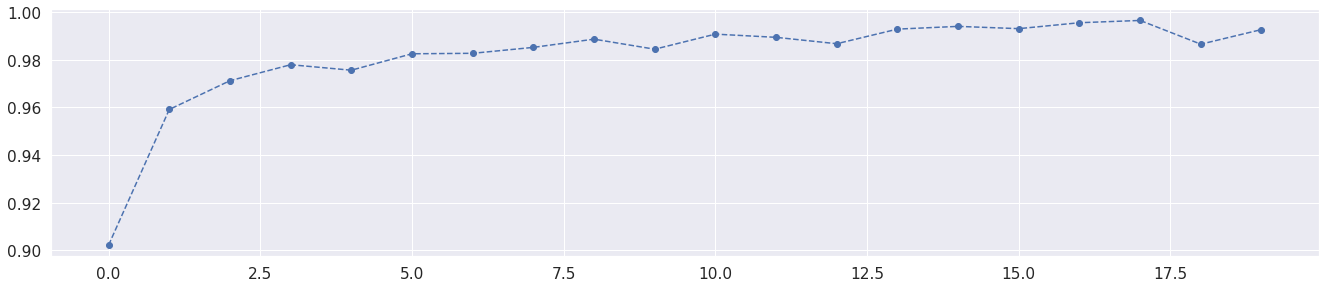

In [ ]:
plot_accuracy_loss(history)